In [1]:
# Import dependencies
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import numpy as np
from datetime import datetime
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import text, inspect

## Reflect Tables into SQLAlchemy ORM

In [2]:
# Create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [3]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

## Explore database structure

In [4]:
# Create inspection object for engine
inspector = inspect(engine)

# Get table names of hawaii.sqlite
table_names = inspector.get_table_names()

for table_name in table_names:
    print(table_name)

measurement
station


In [5]:
# Get column names of table "measurement"
measurement_cols = inspector.get_columns("measurement")

for measurement_col in measurement_cols:
    measurement_col_name = measurement_col["name"]
    measurement_col_type = measurement_col["type"]
    if measurement_col["primary_key"] == 1:
        primary_key_t_f = "True"
    else:
        primary_key_t_f = "False"
    print(f"column name: {measurement_col_name} | data type: {measurement_col_type} | primary key: {primary_key_t_f}")

column name: id | data type: INTEGER | primary key: True
column name: station | data type: TEXT | primary key: False
column name: date | data type: TEXT | primary key: False
column name: prcp | data type: FLOAT | primary key: False
column name: tobs | data type: FLOAT | primary key: False


In [6]:
# Get column names of table "station"
station_cols = inspector.get_columns("station")

for station_col in station_cols:
    station_col_name = station_col["name"]
    station_col_type = station_col["type"]
    if station_col["primary_key"] == 1:
        primary_key_t_f = "True"
    else:
        primary_key_t_f = "False"
    print(f"column name: {station_col_name} | data type: {station_col_type} | primary key: {primary_key_t_f}")

column name: id | data type: INTEGER | primary key: True
column name: station | data type: TEXT | primary key: False
column name: name | data type: TEXT | primary key: False
column name: latitude | data type: FLOAT | primary key: False
column name: longitude | data type: FLOAT | primary key: False
column name: elevation | data type: FLOAT | primary key: False


In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

## Exploratory Precipitation Analysis

In [8]:
# Open session to qury hawaii.sqlite
session = Session(bind=engine)

In [9]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date_str = session.query(func.max(Measurement.date)).first()[0]

most_recent_date_obj = (datetime.strptime(most_recent_date_str, "%Y-%m-%d")).date()
print(most_recent_date_obj)

2017-08-23


In [10]:
# Calculate the date one year from the last date in data set.
year_prior_date = most_recent_date_obj - dt.timedelta(days=365)
print(year_prior_date)

2016-08-23


In [11]:
# Perform a query to retrieve the data and precipitation scores
prcp_query_results = (session.query(Measurement.date, Measurement.prcp)
              .filter(Measurement.date >= '2016-08-23')
              .filter(Measurement.date <= '2017-08-23'))

In [12]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_query_df = pd.read_sql(sql=prcp_query_results.statement, con=engine, parse_dates={"date":"%Y-%m-%d"}).set_index("date")
prcp_query_df

,prcp
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
...,...
2017-08-19,0.09
2017-08-20,NaN
2017-08-21,0.56


In [13]:
# Sort the dataframe by date
prcp_query_df = prcp_query_df.sort_index(axis=0, ascending=True)
prcp_query_df

,prcp
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


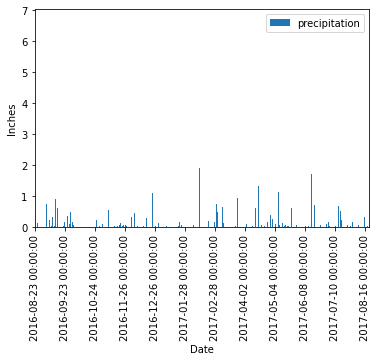

In [14]:
prcp_query_df.plot(kind="bar", rot=90)
plt.xticks(np.arange(0, 2230, step=200)) 
plt.xlabel("Date")
plt.ylabel("Inches")
plt.legend(["precipitation"])
plt.show()

In [19]:
# Print the summary statistics for the precipitation data
prcp_summary_df = prcp_query_df.groupby(by="date").agg(["min","max","mean","median"])
prcp_summary_df

prcp                       
             min   max      mean median
date                                   
2016-08-23  0.00  1.79  0.451667  0.100
2016-08-24  0.08  2.28  1.555000  1.800
2016-08-25  0.00  0.21  0.077143  0.080
2016-08-26  0.00  0.04  0.016667  0.015
2016-08-27  0.00  0.18  0.064000  0.020
...          ...   ...       ...    ...
2017-08-19  0.00  0.09  0.030000  0.000
2017-08-20  0.00  0.01  0.005000  0.005
2017-08-21  0.00  0.56  0.193333  0.020
2017-08-22  0.00  0.50  0.166667  0.000
2017-08-23  0.00  0.45  0.132500  0.040

[366 rows x 4 columns]

## Exploratory Station Analysis

In [19]:
# Design a query to calculate the total number stations in the dataset
station_count_query_results = session.query(Station.id).count()
station_count_query_results

9

In [61]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_activity_query_results = (session.query(Station.id, Station.name, Station.station, func.count(Measurement.id))
                                  .join(Station, Station.station == Measurement.station)
                                  .group_by(Station.id, Station.name, Station.station)
                                  .order_by(func.count(Measurement.id).desc())).all()
station_activity_query_results

[(7, 'WAIHEE 837.5, HI US', 'USC00519281', 2772),
 (1, 'WAIKIKI 717.2, HI US', 'USC00519397', 2724),
 (2, 'KANEOHE 838.1, HI US', 'USC00513117', 2709),
 (6, 'WAIMANALO EXPERIMENTAL FARM, HI US', 'USC00519523', 2669),
 (9, 'MANOA LYON ARBO 785.2, HI US', 'USC00516128', 2612),
 (3, 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 'USC00514830', 2202),
 (8, 'HONOLULU OBSERVATORY 702.2, HI US', 'USC00511918', 1979),
 (4, 'PEARL CITY, HI US', 'USC00517948', 1372),
 (5, 'UPPER WAHIAWA 874.3, HI US', 'USC00518838', 511)]

In [73]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temperature_stats_query_results = (session.query(Measurement.station, 
                                                 func.min(Measurement.tobs), 
                                                 func.max(Measurement.tobs),
                                                 func.avg(Measurement.tobs))
                                   .join(Station, Station.station == Measurement.station)
                                   .filter(Measurement.station == "USC00519281")).all()
temperature_stats_query_results

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [25]:
session.close()